In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from prepare import *
from catboost import CatBoostRegressor, Pool
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from metrics import *
from sklearn.ensemble import RandomForestRegressor
from trasnformer import *
import lightgbm as lgb

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
def invert_sq(x):
    return x ** 2

In [134]:
data = pd.read_csv("../data/train.csv")
#data = data[data["Sales"] < 2000]
data = remove_outliers(data)

y = data["Sales"] ** 0.5
X = data

transformer = Transformer()

transformer.fit(X, False)
X = transformer.transform_lgbm(X)

Int64Index([14166, 17252, 18146, 18690], dtype='int64')


In [147]:
print(y)

0        1.414214
1        2.000000
2        1.414214
3        1.000000
4        6.855655
           ...   
25057    1.000000
25058    2.000000
25059    1.732051
25060    2.236068
25061    8.944272
Name: Sales, Length: 25058, dtype: float64


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
# X_train, y_train = remove_outliers_split(X_train, y_train)
X_train

Brand                      Seller  Comments  Max price  \
16594        Pango             ВАЙЛДБЕРРИЗ ООО      27.0     5180.0   
6027         HUAYU                САТЕЛЛИТ ООО       1.0      500.0   
20879      Аксинья                 АМ-СБЫТ ООО       0.0     1111.0   
19618       GALAXY  МЕГАПОЛИС (7321314837) ООО      42.0     2560.0   
8226    Garden-Lux             АРГУМЕНТ 18 ООО       3.0     2455.0   
...            ...                         ...       ...        ...   
18451      Kitfort             ВАЙЛДБЕРРИЗ ООО       1.0     1590.0   
7985           MBS                РАЗВИТИЕ ООО      10.0     5556.0   
18691          LEX                          ИП       0.0    21195.0   
19780        LEBEN            СКЛАД ДИРЕКТ ООО       0.0     1122.0   
14148  Luazon Home       Фабрика успеха ООО ТД       0.0     1233.0   

       Min price  Average price  Days in stock  Days with sales  Rating  \
16594     5180.0    5180.000000           31.0                0     0.5   
6027       500.0     500.000000           31.0                2     2.5   
20879     1019.0    1019.000000           31.0                1     0.0   
19618     2152.0    2282.325581           31.0               22     0.5   
8226      2399.0    2399.000000           31.0                1     1.5   
...          ...            ...            ...              ...     ...   
18451     1431.0    1565.538462           31.0                9     2.5   
7985      5556.0    5556.000000            0.0                0     0.5   
18691    19490.0   20342.500000           31.0                0     0.0   
19780     1122.0    1122.000000            0.0                0     0.0   
14148     1082.0    1157.500000           31.0                0     0.0   

       Basic Sale  Discount  Weeks with sales  Weeks in stock  \
16594        30.0       0.0                 0               4   
6027          0.0       0.0                 0               4   
20879        52.0      92.0                 0               4   
19618        31.0     408.0                 3               4   
8226         57.0      56.0                 0               4   
...           ...       ...               ...             ...   
18451         0.0     159.0                 1               4   
7985         19.0       0.0                 0               0   
18691        13.0    1705.0                 0               4   
19780        30.0       0.0                 0               0   
14148        50.0     151.0                 0               4   

                ExtraSection  Price scale  
16594       Техника для дома    -0.431986  
6027    Пульты телевизионные    -0.448869  
20879  Чайники электрические    -0.448242  
19618              Кофеварки    -0.408148  
8226        Насосы погружные    -0.373857  
...                      ...          ...  
18451  Насадки для пылесосов    -0.353956  
7985                 Вытяжки    -0.350276  
18691        Варочные панели    -0.063570  
19780         Мультистайлеры    -0.393292  
14148  Чайники электрические    -0.439698  

[20046 rows x 15 columns]

In [138]:

def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')

to_categorical(X_train)
to_categorical(X_test)

cat_features = list(X_train.select_dtypes(include=['category']).columns)
cat_features

['Brand', 'Seller', 'ExtraSection']

In [80]:
import hyperopt
from hyperopt import fmin, tpe, hp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from hyperopt.pyll import scope
from sklearn.metrics import make_scorer
from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold

folds = 4
shuffle = True

# Define the search space for the hyperparameters
space = {
        'objective': 'mape',
        'n_estimators': scope.int(hp.quniform('n_estimators', 100, 20000, 1)),
        'max_depth': scope.int(hp.quniform('max_depth', 2, 30, 1)),
        'num_leaves': scope.int(hp.quniform('num_leaves', 2, 40, 1)),
        'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
        'reg_lambda': hp.loguniform('reg_lambda', -5, 0),
        'learning_rate': hp.loguniform('learning_rate', -5, 0),
        'subsample': hp.loguniform('subsample', -5, 0),
        'colsample_bytree': hp.loguniform('colsample_bytree', -5, 0),
        }

# Define the objective function that hyperopt will minimize
def objective(params):
    clf = lgb.LGBMRegressor(random_state=42, **params)

    kf = KFold(n_splits=folds, shuffle=shuffle)
    loss_list = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        fit_params = {
                      "early_stopping_rounds": 30,
                      "eval_metric": 'rmse',
                      "eval_set": [(X_test_fold, y_test_fold)],
                      'verbose': -1,
                      'categorical_feature': cat_features
                      }

        clf_fold = clone(clf)
        clf_fold.fit(X_train_fold, y_train_fold, **fit_params)

        prediction = clf_fold.predict(X_test_fold)
        loss = smape(invert_sq(prediction), invert_sq(y_test_fold))

        loss_list.append(loss)
    
    score = np.mean(loss_list)

    return score
    
# Run the hyperparameter optimization
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# Print the best hyperparameters
print(best)


  0%|          | 0/100 [00:01<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [139]:
best = {
        'objective': 'huber',
        'n_estimators': 300,
        'max_depth': 15,
        'num_leaves': 38,
        'reg_alpha': 0.08197069567678053,
        'reg_lambda': 0.13678884894104798,
        'learning_rate': 0.09,
        'subsample': 0.012452461513476879,
        'colsample_bytree': 0.9949282543887248,
}

In [140]:
fit_params = {
    "eval_metric": 'huber',
    'verbose': 1,
    'categorical_feature': cat_features
}
lbg_model = lgb.LGBMRegressor(random_state=42,
                              #boosting_type ='dart',
                              objective=best['objective'],
                              n_estimators=int(best['n_estimators']),
                              max_depth=int(best['max_depth']),
                              #num_leaves = int(best['num_leaves']),
                              #reg_alpha=best['reg_alpha'],
                              #reg_lambda=best['reg_lambda'],
                              learning_rate=best['learning_rate'],
                              #subsample=best['subsample'],
                              #colsample_bytree=best['colsample_bytree'],
                              )

lbg_model.fit(X_train, y_train, eval_set = [(X_test, y_test), (X_train, y_train)], early_stopping_rounds = 20,  **fit_params)

[1]	training's huber: 2.29553	valid_0's huber: 2.18498
[2]	training's huber: 2.23786	valid_0's huber: 2.12763
[3]	training's huber: 2.18102	valid_0's huber: 2.07106
[4]	training's huber: 2.12501	valid_0's huber: 2.01537
[5]	training's huber: 2.06987	valid_0's huber: 1.9605
[6]	training's huber: 2.01567	valid_0's huber: 1.9066
[7]	training's huber: 1.96235	valid_0's huber: 1.85365
[8]	training's huber: 1.91001	valid_0's huber: 1.80161
[9]	training's huber: 1.85868	valid_0's huber: 1.75055
[10]	training's huber: 1.80843	valid_0's huber: 1.70061
[11]	training's huber: 1.7592	valid_0's huber: 1.65174
[12]	training's huber: 1.71115	valid_0's huber: 1.60406
[13]	training's huber: 1.66436	valid_0's huber: 1.55769
[14]	training's huber: 1.61867	valid_0's huber: 1.5124
[15]	training's huber: 1.57397	valid_0's huber: 1.46795
[16]	training's huber: 1.53069	valid_0's huber: 1.42508
[17]	training's huber: 1.48879	valid_0's huber: 1.38366
[18]	training's huber: 1.44812	valid_0's huber: 1.34353
[19]	

LGBMRegressor(learning_rate=0.09, max_depth=15, n_estimators=300,
              objective='huber', random_state=42)

In [141]:

evaluate(lbg_model, X_train, y_train, invert_sq)
evaluate(lbg_model, X_test, y_test, invert_sq)

SMAPE: 65.54874554471675
SMAPE: 67.7585226889452


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='huber'>

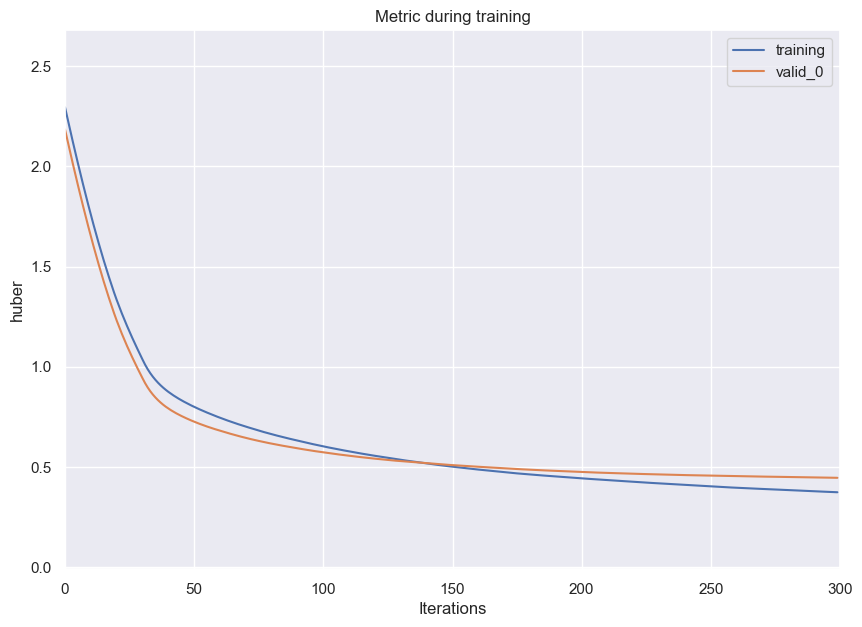

In [142]:
lgb.plot_metric(lbg_model, figsize  = (10,7))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

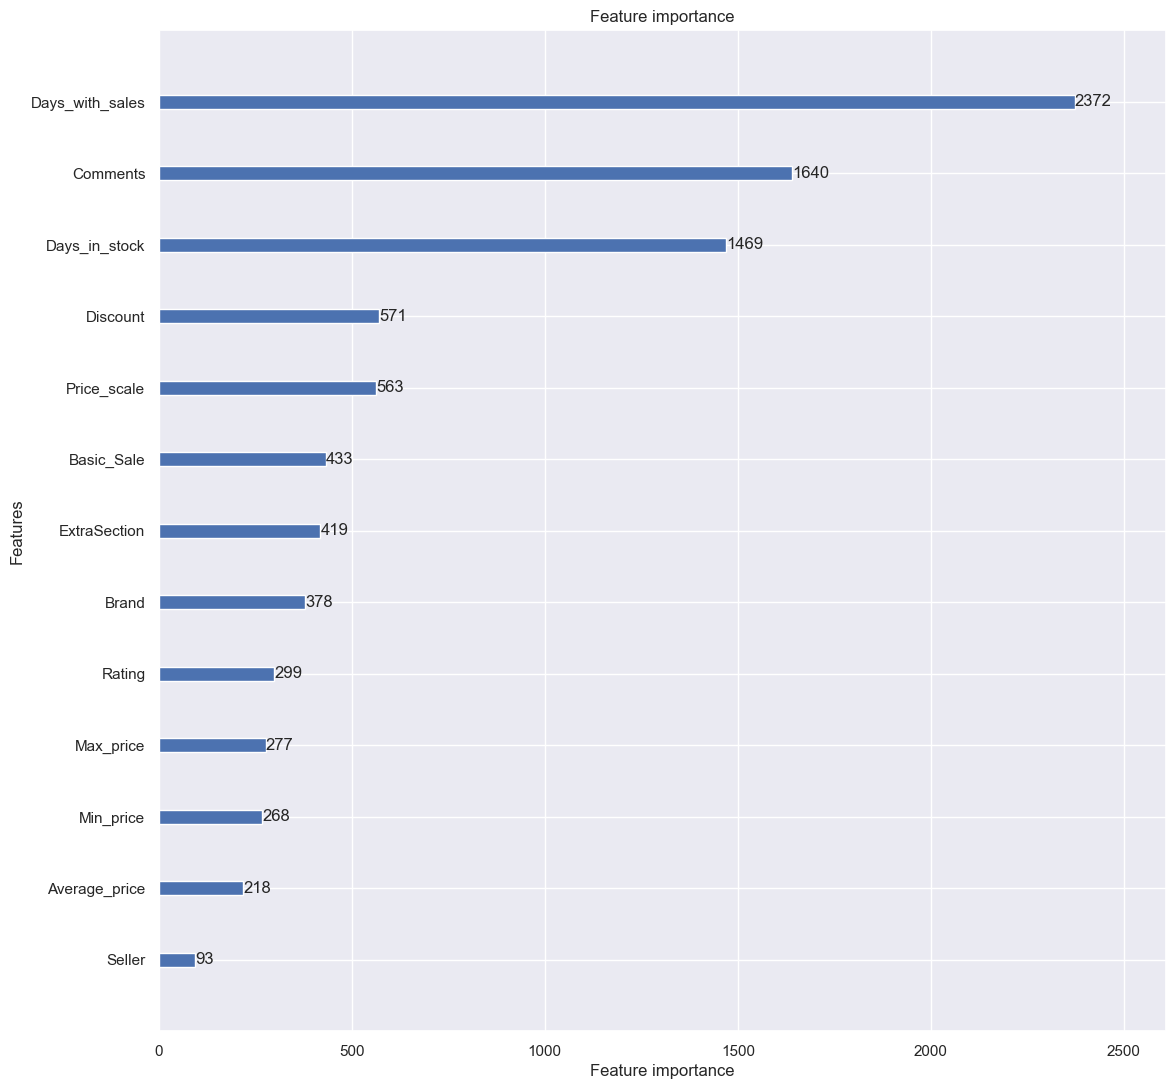

In [143]:
lgb.plot_importance(lbg_model, figsize  = (13,13))


In [144]:
def inv(x):
    return x

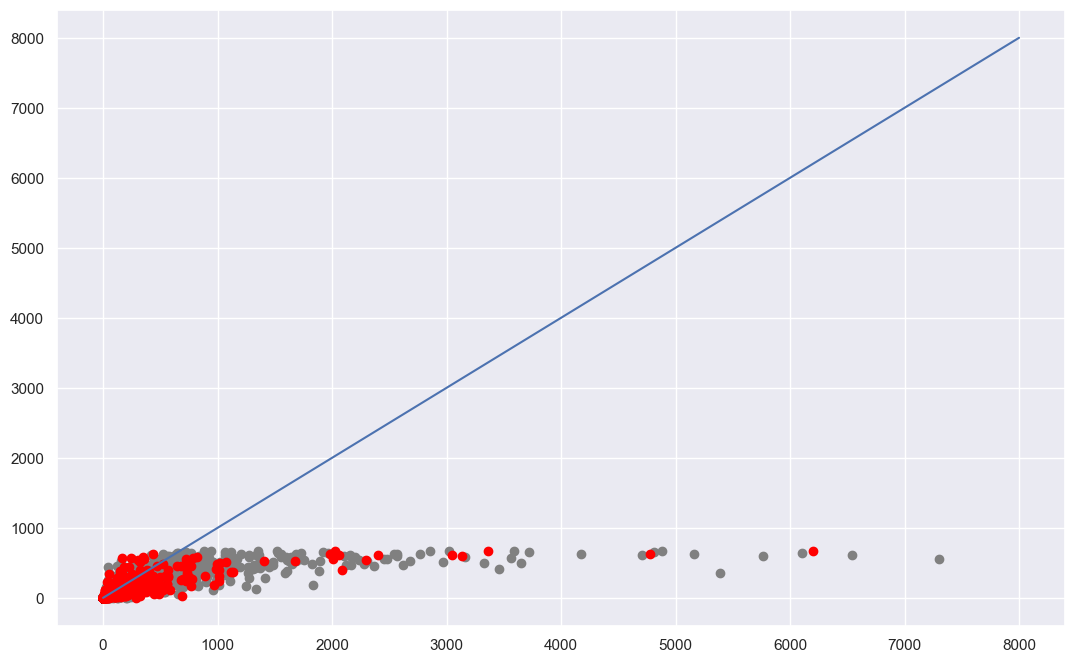

In [145]:
plt.figure(figsize=(13,8))

plt.plot(np.linspace(0, 8000, 2), np.linspace(0, 8000, 2), c = 'b')

plt.scatter(invert_sq(y_train), invert_sq(lbg_model.predict(X_train)), color='gray')
plt.scatter(invert_sq(y_test), invert_sq(lbg_model.predict(X_test)), color='red')


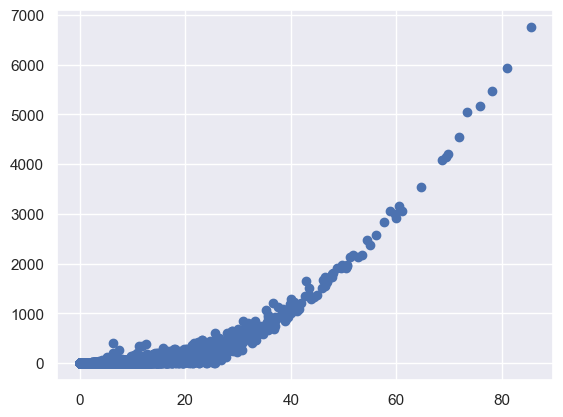

In [73]:
plt.scatter(y_train, np.abs(invert_sq(y_train) - invert_sq(lbg_model.predict(X_train))))